In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter    # to convert xaxis label to dates
from datetime import datetime, timedelta
import pytz
import pandas as pd
import datetime
from datetime import date
import time
import numpy as np


from lz_ignition_dbi.lz_ignition_dbi import IDBIWrapper
import lz_ignition_dbi.lz_ignition_bindata as bindata

#starting from here:
#https://gitlab.com/luxzeplin/sharing/slowcontrolanalysis/-/blob/main/DetectorStatusChecks.ipynb

In [ ]:
tags  = ['5505OHM', '5502DO', 'RAD73', 'DAVISP', '6405FM', '6401FM', '6233PT', '6232PT', '6231PT', '6405RG', 'S1ODROW1', 'S1ODROW2', 'S1ODROW3', 'S1ODROW4', 'S1ODROW5', 'S1ODROW6',
           'DAVIST', 'WATERRT', '5506T', '5507T', 'OD1Temp', 'OD2Temp', 'OD3Temp',
           'WTCORR', 'TATCORR', 'SATCORR', 'BATCORR', 'WTTOPDIFF', 'WTSIDEDIFF', 'WTBOTDIFF'
          ]
label = ['[MOhm/cm]', '[ppb]', '[counts]', 'mbar', 'flow', 'flow', '[mbar]',  '[mbar]', '[mbar]', 'setpoint', '[Hz]', '[Hz]', '[Hz]', '[Hz]', '[Hz]', '[Hz]'
        '[C]', '[C]', '[C]', '[C]', '[C]', '[C]', '[C]',
        '[cm]', '[cm]', '[cm]', '[cm]', '[cm]', '[cm]', '[cm]'
        ]
color = ['b', 'r', 'darkorange', 'peru', 'salmon', 'powderblue', 'cadetblue', 'lime', 'limegreen', 'seagreen', 'darkslategrey',
        'steelblue', 'lightslategrey', 'slateblue', 'darkslateblue',  'midnightblue',  'lightblue', 'maroon', 'lightcoral', 'peachpuff', 
        'b', 'r', 'darkorange', 'peru', 'salmon', 'powderblue', 'cadetblue', 'b', 'r', 'darkorange', 'peru', 'salmon', 'powderblue', 'cadetblue',]

df=pd.DataFrame(list(zip(tags, label, color)),
              columns=['tags','label', 'color'])


days_past=14

In [218]:
axis_type = 'dateLabel' 
TIMEZONE = 'US/Mountain'
DATEFORMAT = '%Y-%-m-%-dT%H:%M'  # see https://strftime.org/

class DateFormat(Formatter):
    """
    This class converts the seconds since unix epoch to date strings
    """
    def __init__(self, format=None, timezone=None):
        self.format = format if format is not None else '%Y-%m-%dT%H:%M'
        self.timezone = timezone if timezone is not None else 'US/Mountain'

    def __call__(self, x, pos=None):
        tz = pytz.timezone(TIMEZONE)
        newticklabel = datetime.datetime.fromtimestamp(x).astimezone(tz).strftime(self.format)
        return newticklabel

dateformatter = DateFormat(DATEFORMAT, TIMEZONE)


In [219]:
# Retrieve the slow control data from the Ignition DB, '2021-12-23T09:30:00' start of SR1

end = datetime.datetime.fromtimestamp(time.time()) # Get today's date
start = end - datetime.timedelta(days=days_past)           # Get date from a week ago

end = end.isoformat()                              # Convert to correct format
start = start.isoformat()

#time between SR1 and SR2

start = '2022-04-19 00:00:01'
end = '2022-10-01 00:00:01'

idbi = IDBIWrapper(known_tags_file='/global/u2/p/penning/work/od_ignition_mon/bp_tag_map_PMTs.json')
idbi.select(tags, start, end)
data = idbi.resolve(dateformat='unix')

# DBI returns times in units of ms. Convert to s for formatter
for t in tags:
    data[t]['times'] = [ x/1000. for x in data[t]['times'] ]    



In [240]:
#need general figure object for things to work later
fig = plt.figure()
def plotIgnition(fname,ylabel,ax=None,options=''):
    if ax is None:
        ax = plt.gca()
    # Make the plot
    ax.plot(data[fname]['times'], data[fname]['vals'], options, label=fname)
    plt.title(fname)
    plt.ylabel(ylabel)
    if '5505OHM' in fname:
        ax.set_ylim(13.8,16)
    if '5502DO' in fname:
        ax.set_ylim(6,25)
    if 'S1ODROW6' in fname:
        ax.set_ylim(40E3,70E3)
    #plt.ylim(38000, 41000)
    ax.legend(frameon=False)
    # Convert UNIX timestamps to human-readable
    ax.xaxis.set_major_formatter(dateformatter)
    # Rotate the tick labels and align them to the right
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('right')
        tick.set_rotation(20)
    fig.subplots_adjust(bottom=0.2, left=0.15)
    return ax


<Figure size 432x288 with 0 Axes>

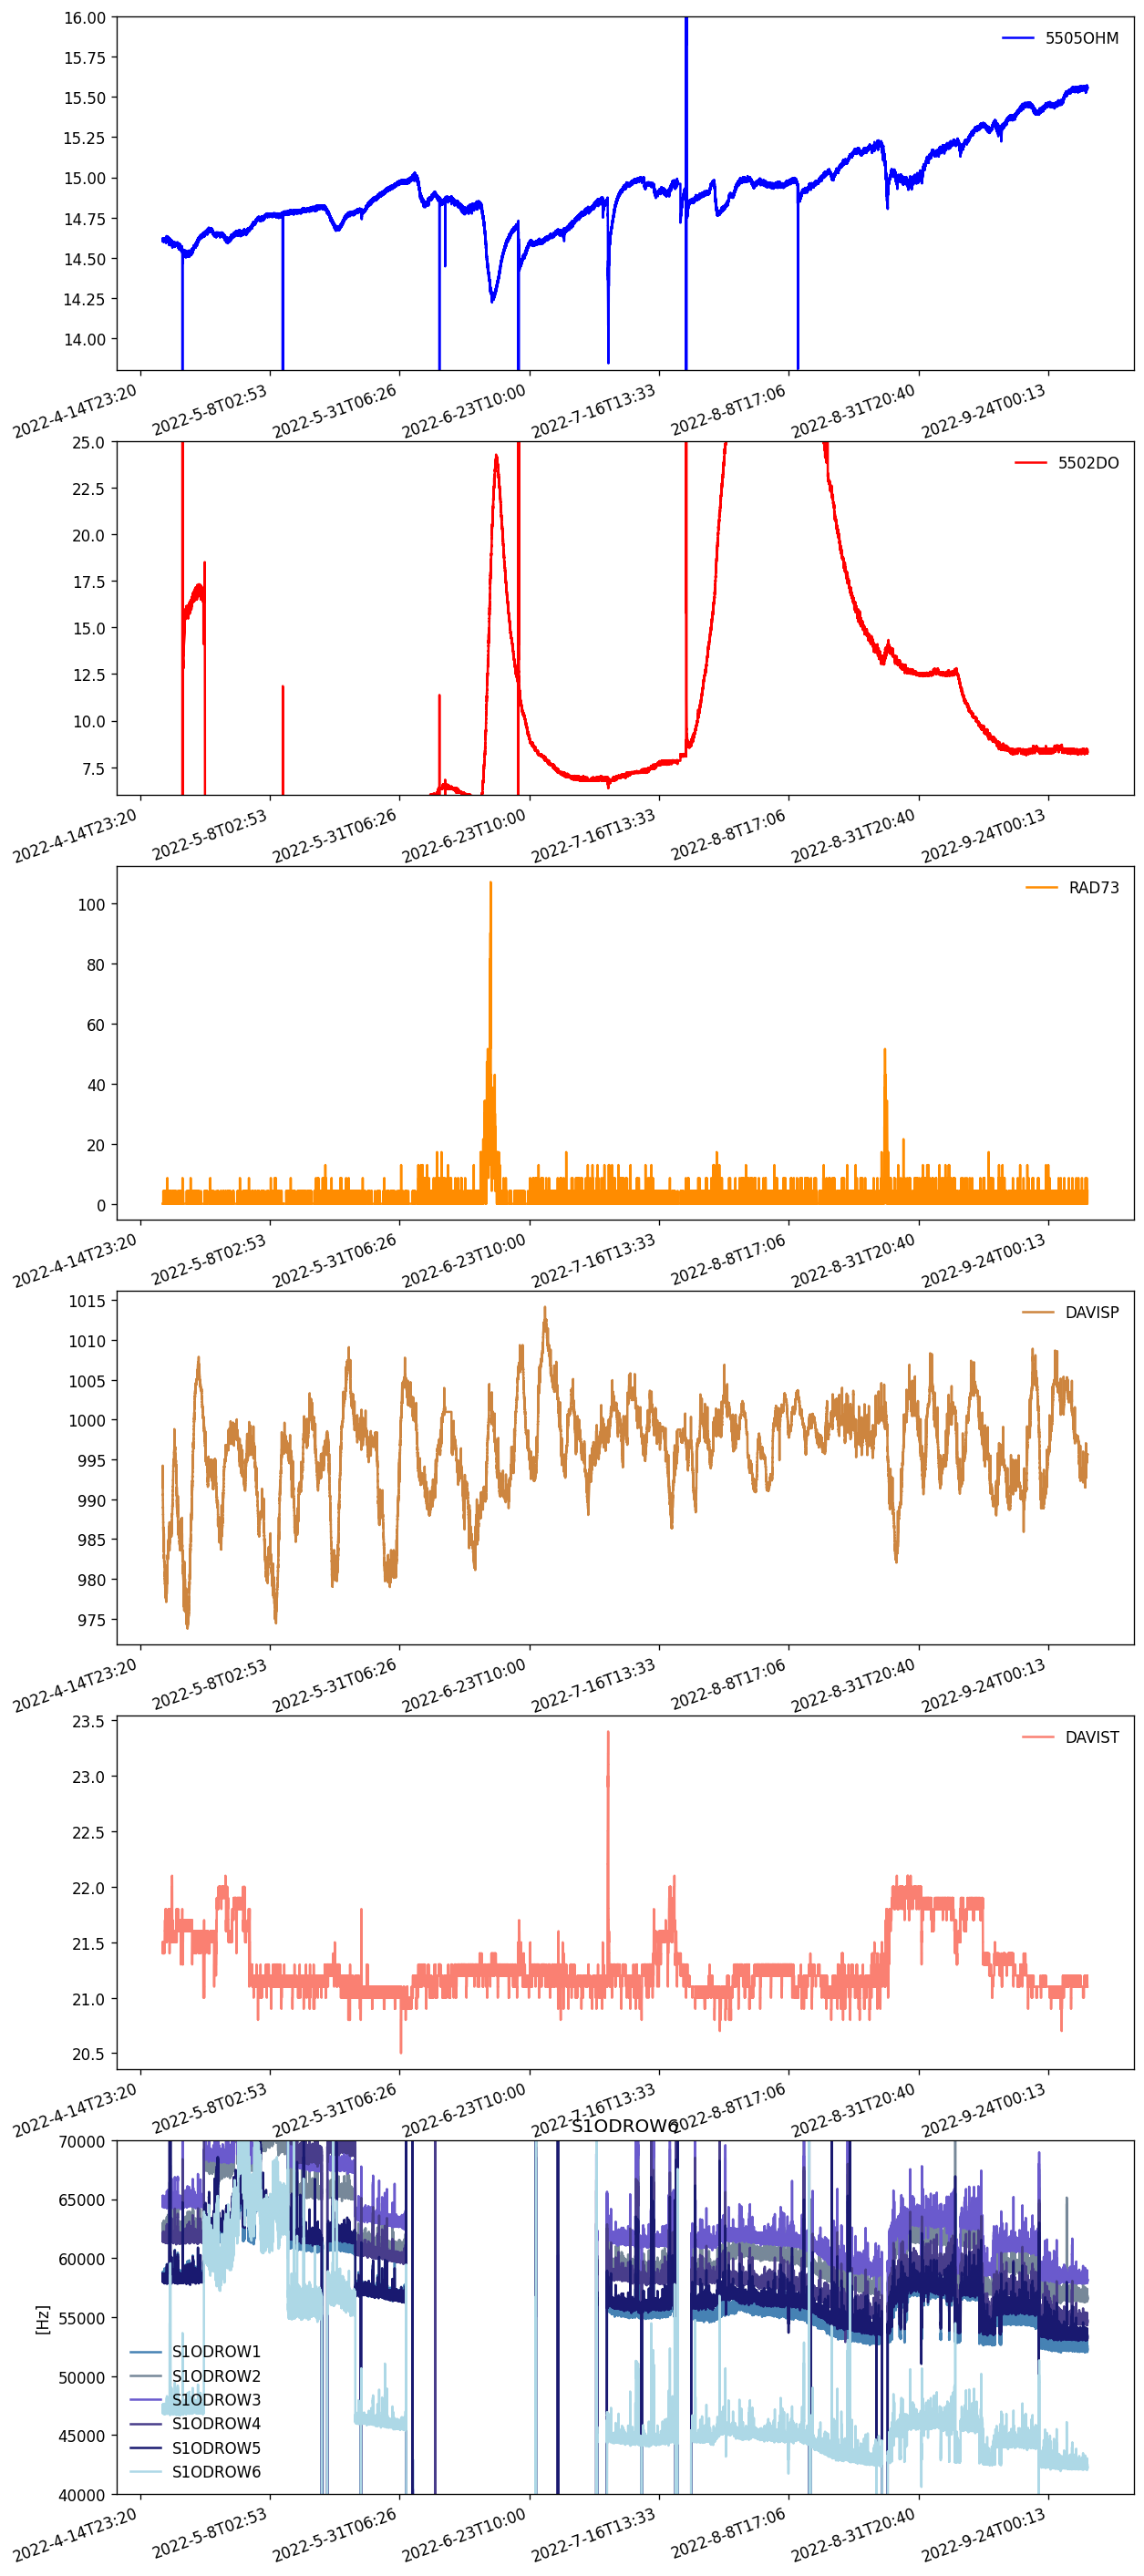

In [241]:
#plot core plots
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=False, figsize=(12,30), dpi=120)
plotIgnition('5505OHM', 'Resistivity [MOhm cm]', ax1, 'b')
plotIgnition('5502DO', 'DO2 [ppb]', ax2, 'r')
plotIgnition('RAD73', 'RAD [cts]', ax3, 'darkorange')
plotIgnition('DAVISP', 'p [mbar]', ax4,  'peru')
plotIgnition('DAVIST', 't [C]', ax5,  'salmon')
plotIgnition('S1ODROW1', '[Hz]', ax6,  'steelblue')
plotIgnition('S1ODROW2', '[Hz]', ax6,  'lightslategrey')
plotIgnition('S1ODROW3', '[Hz]', ax6,  'slateblue')
plotIgnition('S1ODROW4', '[Hz]', ax6,  'darkslateblue')
plotIgnition('S1ODROW5', '[Hz]', ax6,  'midnightblue')
plotIgnition('S1ODROW6', '[Hz]', ax6,  'lightblue')
f.savefig('core_monitor.png')

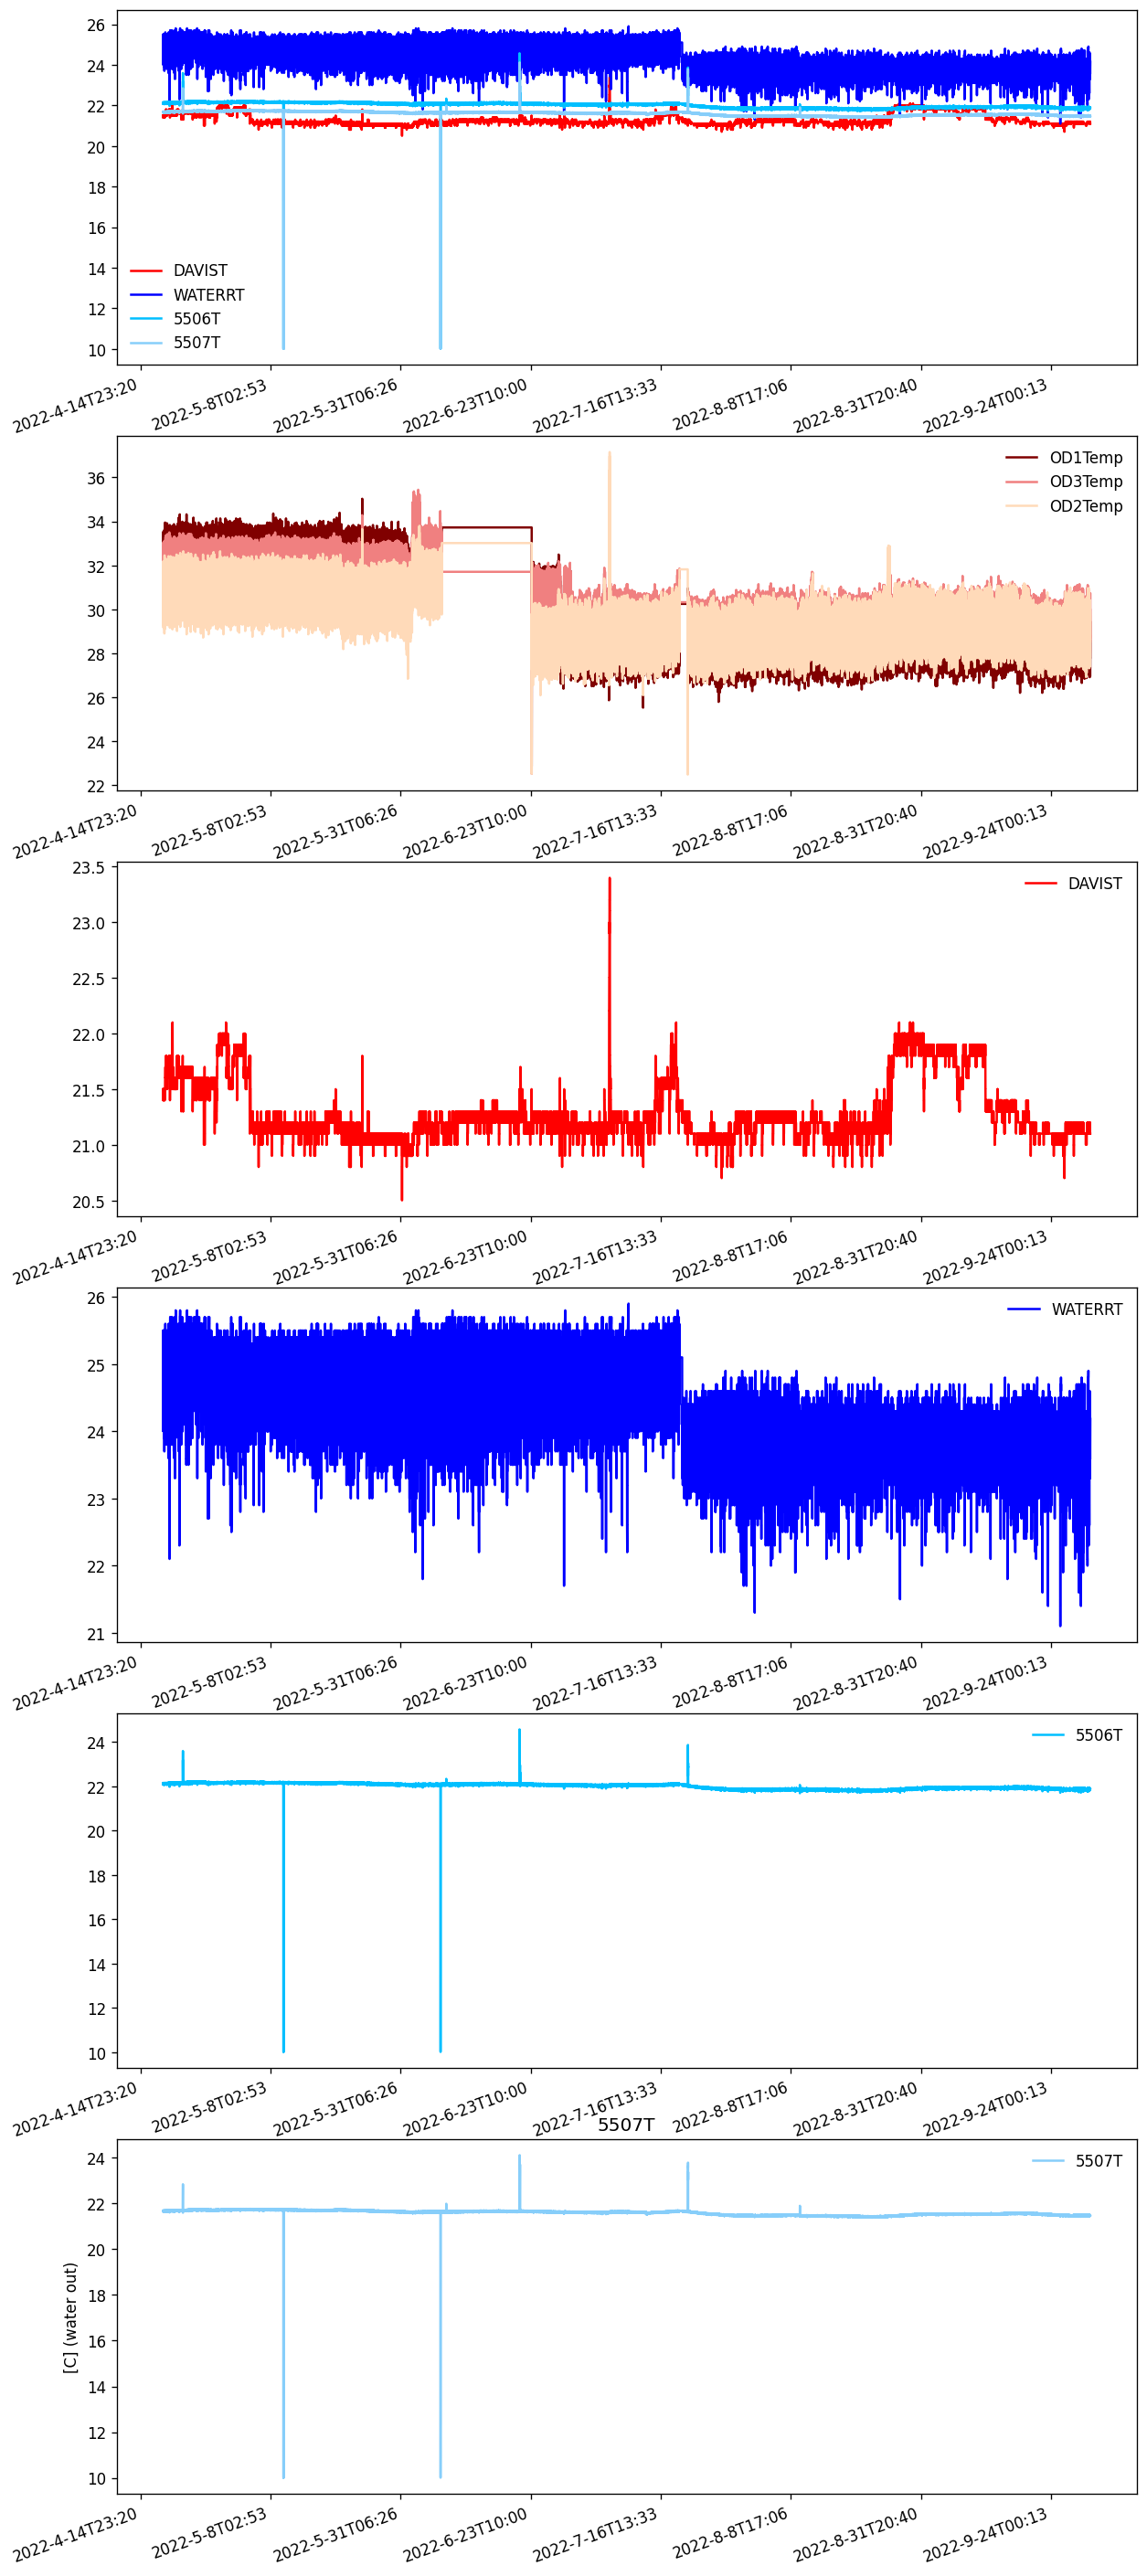

In [242]:
#plot temp plots
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=False, figsize=(12,30), dpi=120)

plotIgnition('DAVIST', '[C]', ax1,  'red')
plotIgnition('WATERRT', '[C]', ax1,  'blue')
plotIgnition('5506T', '[C] (water in)', ax1,  'deepskyblue')
plotIgnition('5507T', '[C] (water out)', ax1,  'lightskyblue')
plotIgnition('OD1Temp', '[C]', ax2,  'maroon')
plotIgnition('OD3Temp', '[C]', ax2,  'lightcoral')
plotIgnition('OD2Temp', '[C]', ax2,  'peachpuff')
plotIgnition('DAVIST', '[C]', ax3,  'red')
plotIgnition('WATERRT', '[C]', ax4,  'blue')
plotIgnition('5506T', '[C] (water in)', ax5,  'deepskyblue')
plotIgnition('5507T', '[C] (water out)', ax6,  'lightskyblue')

f.savefig('water_monitor.png')

In [243]:
#plot rats individually and together plots
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, sharex=True, figsize=(12,35), dpi=120)
plotIgnition('S1ODROW1', '[Hz]', ax1,  'steelblue')
plotIgnition('S1ODROW2', '[Hz]', ax1,  'lightslategrey')
plotIgnition('S1ODROW3', '[Hz]', ax1,  'slateblue')
plotIgnition('S1ODROW4', '[Hz]', ax1,  'darkslateblue')
plotIgnition('S1ODROW5', '[Hz]', ax1,  'midnightblue')
plotIgnition('S1ODROW6', '[Hz]', ax1,  'lightblue')
plotIgnition('S1ODROW1', '[Hz]', ax2,  'steelblue')
plotIgnition('S1ODROW2', '[Hz]', ax3,  'lightslategrey')
plotIgnition('S1ODROW3', '[Hz]', ax4,  'slateblue')
plotIgnition('S1ODROW4', '[Hz]', ax5,  'darkslateblue')
plotIgnition('S1ODROW5', '[Hz]', ax6,  'midnightblue')
plotIgnition('S1ODROW6', '[Hz]', ax7,  'lightblue')
f.savefig('rates_monitor.png')

<ipython-input-244-9925d518110e>:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  f.savefig('filling_monitor.png')


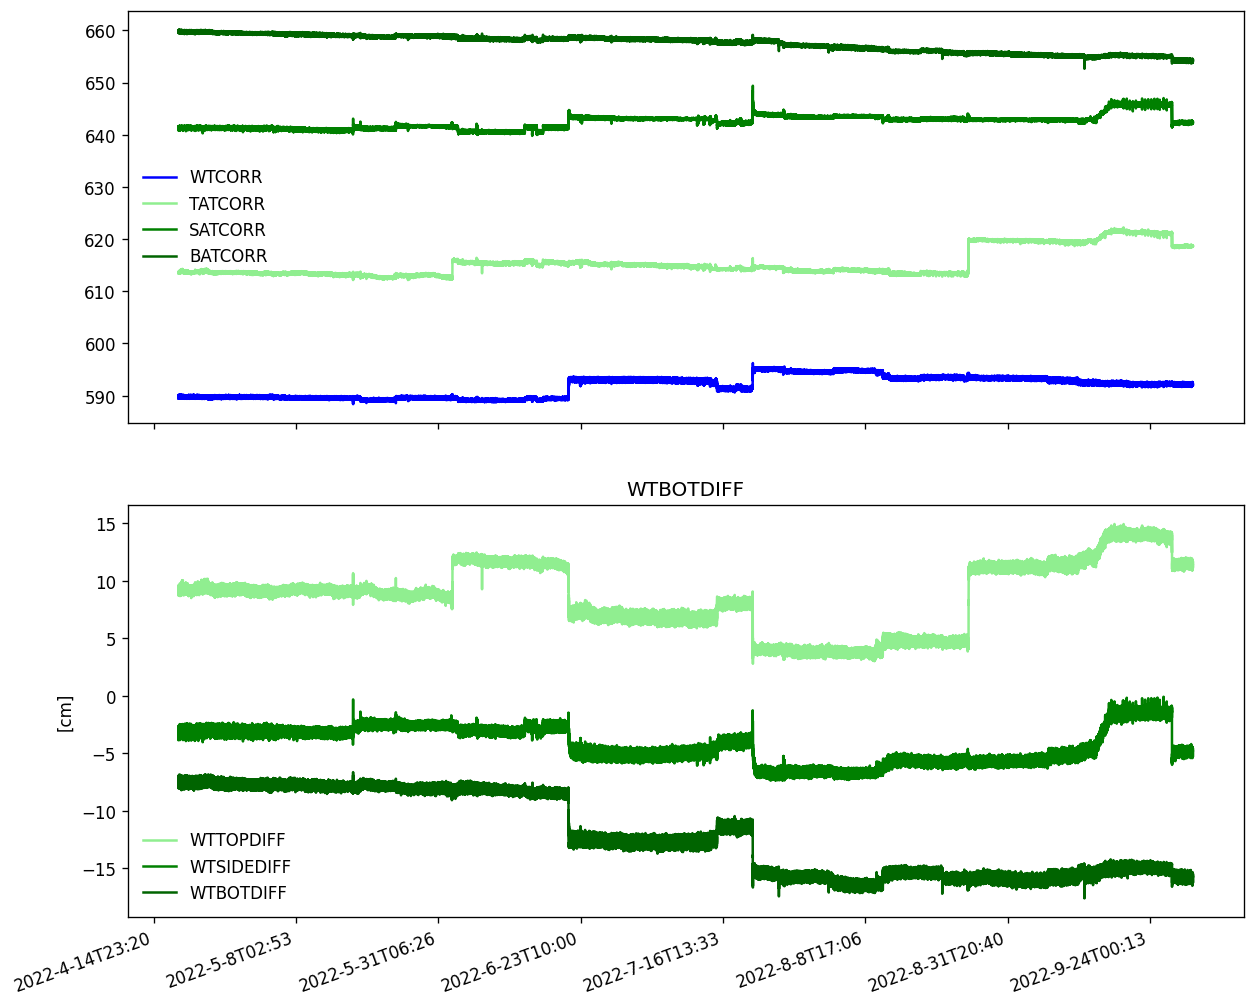

In [244]:
#plot filling plots
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,10), dpi=120)

plotIgnition('WTCORR', '[cm]', ax1,  'blue')
plotIgnition('TATCORR', '[cm]', ax1,  'lightgreen')
plotIgnition('SATCORR', '[cm]', ax1,  'green')
plotIgnition('BATCORR', '[cm]', ax1,  'darkgreen')
plotIgnition('WTTOPDIFF', '[cm]', ax2,  'lightgreen')
plotIgnition('WTSIDEDIFF', '[cm]', ax2,  'green')
plotIgnition('WTBOTDIFF', '[cm]', ax2,  'darkgreen')
f.savefig('filling_monitor.png')

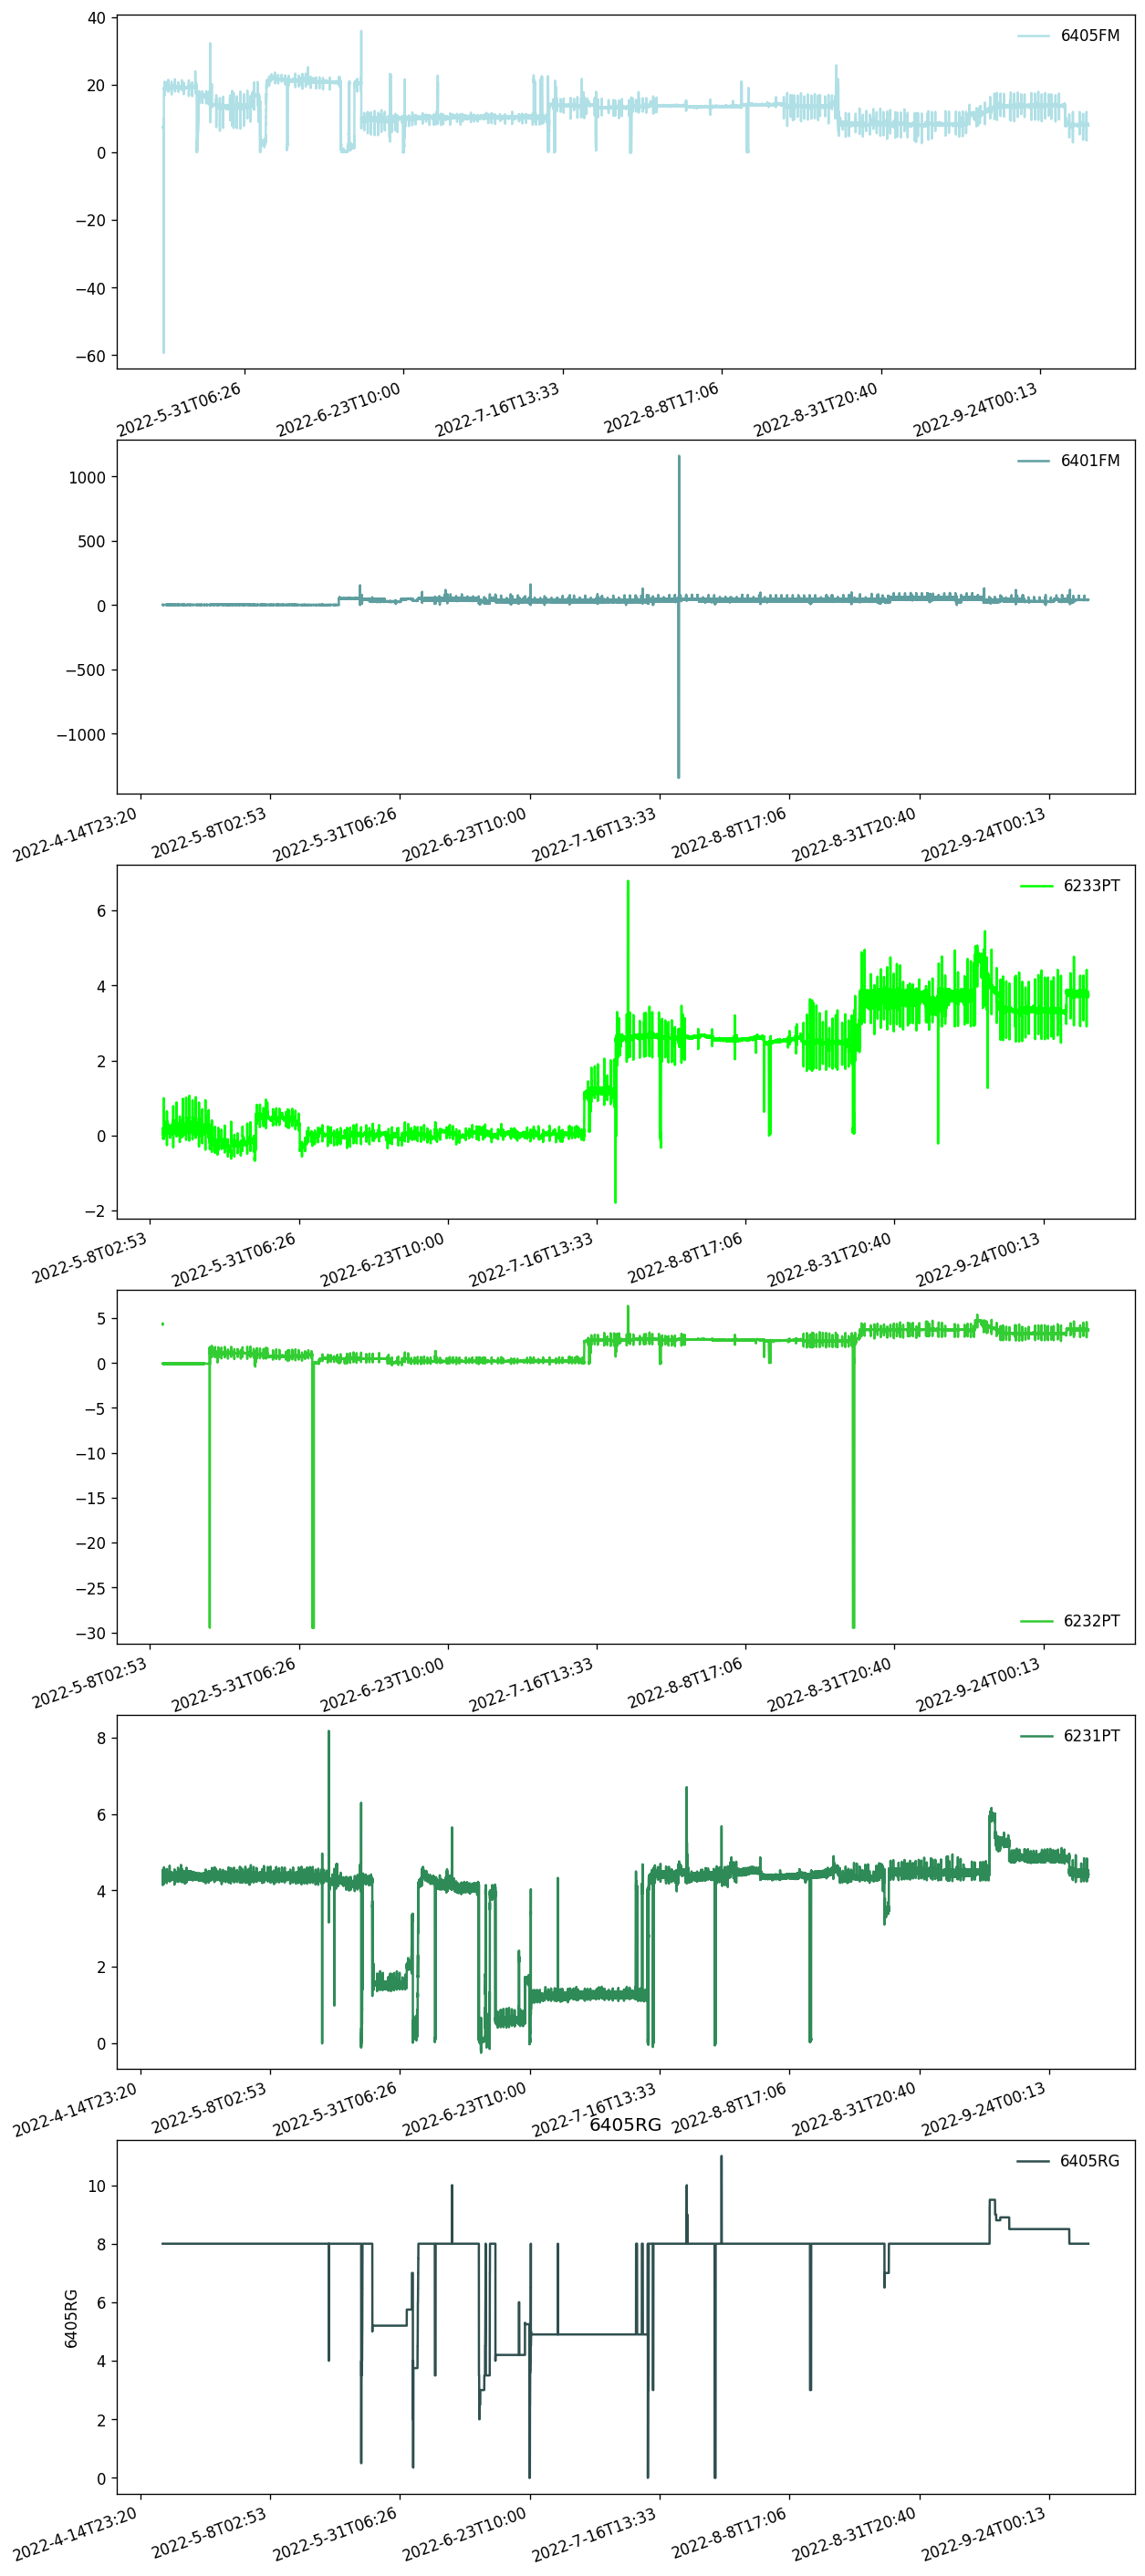

In [245]:
#plot purge plots
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=False, figsize=(12,30), dpi=120)
plotIgnition('6405FM', '6405FM', ax1,  'powderblue')
plotIgnition('6401FM', '6401FM', ax2,  'cadetblue')
plotIgnition('6233PT', '6233PT', ax3,  'lime')
plotIgnition('6232PT', '6232PT', ax4,  'limegreen')
plotIgnition('6231PT', '6231PT', ax5,  'seagreen')
plotIgnition('6405RG', '6405RG', ax6,  'darkslategrey')
f.savefig('purge_monitor.png')